<a href="https://colab.research.google.com/github/FranciscoAguiar/DataScienceProgramming/blob/master/Classificadores2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_predict, TimeSeriesSplit, cross_val_score,cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix,r2_score, precision_score, recall_score, f1_score,cohen_kappa_score
import time
import warnings
from collections import Counter
from imblearn.over_sampling import ADASYN
warnings.filterwarnings("ignore", category=DeprecationWarning)
import shap
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

In [2]:
!pip install shap

     |████████████████████████████████| 564 kB 7.2 MB/s 


# Data Acquisition

In [4]:
dataset = pd.read_csv('combined.csv', sep=',')
datasetLi = pd.read_csv('combinedLIWC.csv', sep=',')
datasetCo = pd.read_csv('combined_CohMetrix.csv', sep=',')

In [ ]:
dataset.describe()

,id,classe
count,1000.000000,1000.000000
mean,8887.011000,0.890000
std,4957.123671,0.313046
min,20.000000,0.000000
25%,1649.750000,1.000000
50%,11987.000000,1.000000
75%,12796.750000,1.000000
max,13814.000000,1.000000


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        1000 non-null   int64 
 1   feedback  996 non-null    object
 2   classe    1000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 23.6+ KB


In [ ]:
dataset.shape

(1000, 3)

In [ ]:
dataset["classe"].value_counts()

1    890
0    110
Name: classe, dtype: int64

# Desbalanceamento

Class 0: 110
Class 1: 890
Proportion: 0.12 : 1


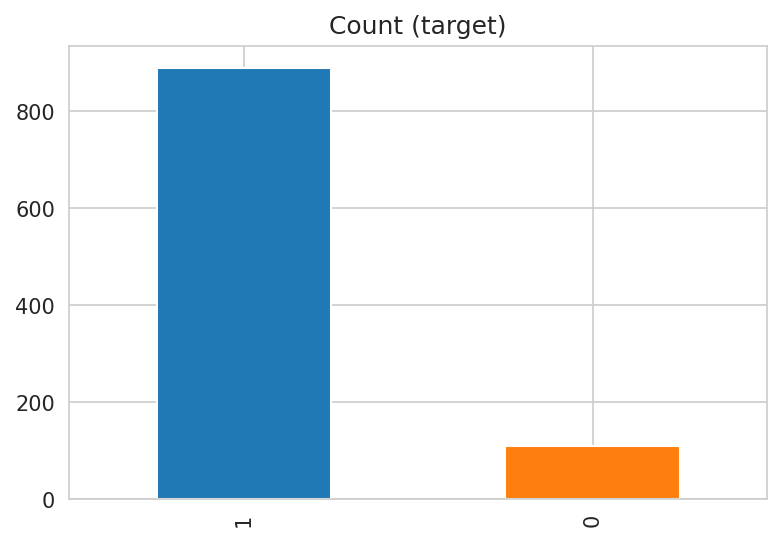

In [ ]:
target_count = dataset.classe.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
target_count.plot(kind='bar', title='Count (target)',color = ['#1F77B4', '#FF7F0E']);

# Data Exploration

In [ ]:
dataset.head(20)

,id,feedback,classe
0,23,Ler outros textos sobre o assunto para lher da...,0
1,24,Procure ler mais; para escrever mais acerca do...,0
2,35,Texto bom; precisa apenas ler mais um pouco; p...,0
3,37,Ter cuidado com copias da internet.,0
4,68,Carssimo; o trabalho precisa de uma sistematiz...,1
5,286,Ol Wilma! Na sua postagem no consta o nom...,0
6,665,Faltaram alguns elementos: referncias etc.,0
7,804,Bom dia Ana Lcia! De acordo com a tarefa da we...,1
8,842,Boa tarde Ccero! o motivo da sua pontuao foi i...,1
9,1098,Bom dia!!! cuidado com os erros ortogrficos e ...,0


In [ ]:
datasetCo.tail()

,ID,cm.DESPC,cm.DESSC,cm.DESWC,cm.DESPL,cm.DESPLd,cm.DESSL,cm.DESSLd,cm.DESWLsy,cm.DESWLsyd,cm.DESWLlt,cm.DESWLltd,cm.CRFNO1,cm.CRFAO1,cm.CRFSO1,cm.CRFNOa,cm.CRFAOa,cm.CRFSOa,cm.CRFCWO1,cm.CRFCWO1d,cm.CRFCWOa,cm.CRFCWOad,cm.CRFANP1,cm.CRFANPa,cm.LSASS1,cm.LSASS1d,cm.LSASSp,cm.LSASSpd,cm.LSAPP1,cm.LSAPP1d,cm.LSAGN,cm.LSAGNd,cm.LDTTRc,cm.LDTTRa,cm.LDMTLDa,cm.LDVOCDa,cm.CNCAll,cm.CNCCaus,cm.CNCLogic,cm.CNCADC,...,cm.SMCAUSv,cm.SMCAUSvp,cm.SMCAUSr,cm.SMCAUSlsa,cm.SMCAUSwn,cm.SYNLE,cm.SYNMEDpos,cm.SYNMEDwrd,cm.SYNMEDlem,cm.SYNSTRUTa,cm.SYNSTRUTt,cm.DRNP,cm.DRVP,cm.DRAP,cm.DRPP,cm.DRPVAL,cm.DRNEG,cm.DRGERUND,cm.DRINF,cm.WRDNOUN,cm.WRDVERB,cm.WRDADJ,cm.WRDADV,cm.WRDPRO,cm.WRDPRP1s,cm.WRDPRP1p,cm.WRDPRP2,cm.WRDPRP3s,cm.WRDPRP3p,cm.WRDFRQc,cm.WRDFRQa,cm.WRDFRQmc,cm.WRDAOAc,cm.WRDFAMc,cm.WRDCNCc,cm.WRDIMGc,cm.WRDMEAc,cm.RDFRE,cm.RDFKGL,cm.RDL2
995,13809,1,2,28,2.0,0.0,12.000000,11.000000,2.250000,1.404358,5.625000,3.603384,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0.0,0.0,0,0,0.250000,0.433013,1.000000,0.956522,148.12,0.00000,1.0,1.0,2.0,0.0,...,0.0,1.0,1.0,0.250000,1.0,0.333333,1.000000,1.0,1.0,0.000000,0.000000,0,0,0,0,0,0,0,1,5,1,4,1,0,0,0,0,0,0,6.163387,1.818627,5.906580,477.500000,592.384615,270.666667,291.153846,320.909091,-13.320000,18.098333,86.123599
996,13810,1,2,66,2.0,0.0,29.500000,27.500000,1.969697,1.149845,5.000000,2.810392,0,0,0,0,0,0,0.038624,0.029450,0.036554,0.040336,0,0,0.0,0.0,0.0,0.0,0,0,0.250000,0.433013,0.969697,0.850000,112.00,0.88498,3.0,1.0,3.0,0.0,...,0.0,1.0,1.0,0.250000,4.0,3.000000,0.807407,1.0,1.0,0.000000,0.000000,1,2,0,0,0,0,0,3,19,7,5,2,2,0,0,0,0,0,6.181342,1.821535,5.762268,427.333333,572.047619,313.500000,339.571429,334.562500,0.523008,20.515000,84.936501
997,13811,1,2,37,2.0,0.0,16.500000,15.500000,2.027027,1.213042,4.969697,2.876075,1,1,1,1,1,1,0.078125,0.078125,0.052083,0.073657,1,1,0.0,0.0,0.0,0.0,0,0,0.250000,0.433013,0.941176,0.818182,50.82,0.00000,3.0,2.0,3.0,0.0,...,1.0,3.0,1.0,0.250000,2.0,1.333333,1.000000,1.0,1.0,0.000000,0.000000,1,0,0,0,0,0,0,0,10,2,3,2,3,0,0,0,0,0,6.300706,1.840662,6.300706,384.571429,583.000000,285.450000,298.666667,317.888889,8.069318,16.232879,98.955636
998,13813,1,3,28,3.0,0.0,7.666667,10.143416,1.964286,1.170063,5.086957,2.764889,0,0,0,0,0,0,0.022727,0.022727,0.015152,0.021427,0,0,0.0,0.0,0.0,0.0,0,0,0.111111,0.314270,1.000000,0.956522,148.12,0.00000,1.0,1.0,1.0,0.0,...,1.0,2.0,0.5,0.111111,2.0,1.000000,0.950000,1.0,1.0,0.490914,0.490914,1,0,0,0,0,0,0,0,8,2,5,0,2,0,0,0,0,0,6.096397,1.807698,5.301215,426.000000,592.285714,223.142857,246.857143,298.857143,15.140290,13.052174,103.964498
999,13814,1,3,28,3.0,0.0,7.666667,10.143416,2.000000,1.217161,5.173913,2.792103,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0.0,0.0,0,0,0.111111,0.314270,1.000000,0.956522,148.12,0.00000,1.0,1.0,1.0,0.0,...,1.0,2.0,0.5,0.111111,2.0,0.000000,0.666667,1.0,1.0,0.420973,0.420973,1,0,0,0,0,0,0,0,8,2,5,0,2,0,0,0,0,0,6.066792,1.802830,5.275471,426.000000,592.285714,223.142857,246.857143,298.857143,11.462029,13.565217,97.918037


In [5]:
datasetCo['classe'] = dataset['classe']
datasetCo.head()

,ID,cm.DESPC,cm.DESSC,cm.DESWC,cm.DESPL,cm.DESPLd,cm.DESSL,cm.DESSLd,cm.DESWLsy,cm.DESWLsyd,cm.DESWLlt,cm.DESWLltd,cm.CRFNO1,cm.CRFAO1,cm.CRFSO1,cm.CRFNOa,cm.CRFAOa,cm.CRFSOa,cm.CRFCWO1,cm.CRFCWO1d,cm.CRFCWOa,cm.CRFCWOad,cm.CRFANP1,cm.CRFANPa,cm.LSASS1,cm.LSASS1d,cm.LSASSp,cm.LSASSpd,cm.LSAPP1,cm.LSAPP1d,cm.LSAGN,cm.LSAGNd,cm.LDTTRc,cm.LDTTRa,cm.LDMTLDa,cm.LDVOCDa,cm.CNCAll,cm.CNCCaus,cm.CNCLogic,cm.CNCADC,...,cm.SMCAUSvp,cm.SMCAUSr,cm.SMCAUSlsa,cm.SMCAUSwn,cm.SYNLE,cm.SYNMEDpos,cm.SYNMEDwrd,cm.SYNMEDlem,cm.SYNSTRUTa,cm.SYNSTRUTt,cm.DRNP,cm.DRVP,cm.DRAP,cm.DRPP,cm.DRPVAL,cm.DRNEG,cm.DRGERUND,cm.DRINF,cm.WRDNOUN,cm.WRDVERB,cm.WRDADJ,cm.WRDADV,cm.WRDPRO,cm.WRDPRP1s,cm.WRDPRP1p,cm.WRDPRP2,cm.WRDPRP3s,cm.WRDPRP3p,cm.WRDFRQc,cm.WRDFRQa,cm.WRDFRQmc,cm.WRDAOAc,cm.WRDFAMc,cm.WRDCNCc,cm.WRDIMGc,cm.WRDMEAc,cm.RDFRE,cm.RDFKGL,cm.RDL2,classe
0,23,1,1,18,1.0,0.0,17.0,0.000000,1.888889,0.900254,5.117647,2.193100,0,0,0,0,0,0,NaN,NaN,0.000000,0.000000,0,0,0.000000,0.0,NaN,NaN,0,0,1.000000,0.000000,0.900000,0.882353,40.46,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.000000,1.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,2,5,2,2,1,0,0,0,0,0,0,6.132208,1.813555,6.132208,464.666667,559.000000,356.142857,339.285714,336.250000,25.356471,13.945882,NaN,0
1,24,1,2,24,2.0,0.0,10.5,0.500000,1.916667,1.100066,5.095238,2.670915,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,0,0.393322,0.0,0.393322,0.000000,0,0,0.696661,0.303339,0.923077,0.952381,123.48,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.674710,6.0,0.50,0.833333,0.916667,0.916667,0.000000,0.000000,0,2,0,0,0,0,0,5,3,7,0,3,0,0,0,0,0,0,6.640197,1.893142,6.308187,375.000000,588.666667,303.000000,323.444444,346.000000,27.485000,11.910000,95.041286,0
2,35,1,2,31,2.0,0.0,12.5,0.500000,1.741935,0.964978,5.040000,2.424541,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,0,0.135975,0.0,0.135975,0.000000,0,0,0.567988,0.432012,1.000000,0.960000,175.00,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.766387,5.0,0.25,0.944444,1.000000,1.000000,0.000000,0.000000,1,3,0,0,0,0,0,4,5,6,2,3,0,0,0,0,0,0,6.633897,1.892192,6.357485,403.000000,590.090909,312.333333,339.818182,375.000000,32.505000,11.706667,96.135954,0
3,37,1,1,7,1.0,0.0,6.0,0.000000,1.857143,1.069045,4.833333,2.266912,0,0,0,0,0,0,NaN,NaN,0.000000,0.000000,0,0,0.000000,0.0,NaN,NaN,0,0,1.000000,0.000000,1.000000,1.000000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.000000,1.0,1.00,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,6.600221,1.887103,6.600221,269.000000,561.000000,422.500000,413.500000,349.500000,31.545000,10.350000,NaN,0
4,68,1,4,32,4.0,0.0,6.5,3.640055,1.937500,1.268413,5.500000,3.388328,0,0,0,0,0,0,0.020833,0.029463,0.019189,0.027286,0,0,0.000000,0.0,0.023908,0.053461,0,0,0.142931,0.327327,1.000000,0.920000,87.50,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.122583,2.0,1.25,1.000000,1.000000,1.000000,0.855264,0.855264,1,2,0,0,0,0,0,1,8,5,1,0,0,0,0,0,0,0,6.422688,1.859837,5.138150,486.000000,599.444444,245.375000,264.666667,293.571429,17.755250,12.335500,122.581573,1


In [6]:
datasetCo.drop(columns=['ID'],inplace=True)
datasetCo.head()

,cm.DESPC,cm.DESSC,cm.DESWC,cm.DESPL,cm.DESPLd,cm.DESSL,cm.DESSLd,cm.DESWLsy,cm.DESWLsyd,cm.DESWLlt,cm.DESWLltd,cm.CRFNO1,cm.CRFAO1,cm.CRFSO1,cm.CRFNOa,cm.CRFAOa,cm.CRFSOa,cm.CRFCWO1,cm.CRFCWO1d,cm.CRFCWOa,cm.CRFCWOad,cm.CRFANP1,cm.CRFANPa,cm.LSASS1,cm.LSASS1d,cm.LSASSp,cm.LSASSpd,cm.LSAPP1,cm.LSAPP1d,cm.LSAGN,cm.LSAGNd,cm.LDTTRc,cm.LDTTRa,cm.LDMTLDa,cm.LDVOCDa,cm.CNCAll,cm.CNCCaus,cm.CNCLogic,cm.CNCADC,cm.CNCTemp,...,cm.SMCAUSvp,cm.SMCAUSr,cm.SMCAUSlsa,cm.SMCAUSwn,cm.SYNLE,cm.SYNMEDpos,cm.SYNMEDwrd,cm.SYNMEDlem,cm.SYNSTRUTa,cm.SYNSTRUTt,cm.DRNP,cm.DRVP,cm.DRAP,cm.DRPP,cm.DRPVAL,cm.DRNEG,cm.DRGERUND,cm.DRINF,cm.WRDNOUN,cm.WRDVERB,cm.WRDADJ,cm.WRDADV,cm.WRDPRO,cm.WRDPRP1s,cm.WRDPRP1p,cm.WRDPRP2,cm.WRDPRP3s,cm.WRDPRP3p,cm.WRDFRQc,cm.WRDFRQa,cm.WRDFRQmc,cm.WRDAOAc,cm.WRDFAMc,cm.WRDCNCc,cm.WRDIMGc,cm.WRDMEAc,cm.RDFRE,cm.RDFKGL,cm.RDL2,classe
0,1,1,18,1.0,0.0,17.0,0.000000,1.888889,0.900254,5.117647,2.193100,0,0,0,0,0,0,NaN,NaN,0.000000,0.000000,0,0,0.000000,0.0,NaN,NaN,0,0,1.000000,0.000000,0.900000,0.882353,40.46,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.000000,1.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,2,5,2,2,1,0,0,0,0,0,0,6.132208,1.813555,6.132208,464.666667,559.000000,356.142857,339.285714,336.250000,25.356471,13.945882,NaN,0
1,1,2,24,2.0,0.0,10.5,0.500000,1.916667,1.100066,5.095238,2.670915,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,0,0.393322,0.0,0.393322,0.000000,0,0,0.696661,0.303339,0.923077,0.952381,123.48,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.674710,6.0,0.50,0.833333,0.916667,0.916667,0.000000,0.000000,0,2,0,0,0,0,0,5,3,7,0,3,0,0,0,0,0,0,6.640197,1.893142,6.308187,375.000000,588.666667,303.000000,323.444444,346.000000,27.485000,11.910000,95.041286,0
2,1,2,31,2.0,0.0,12.5,0.500000,1.741935,0.964978,5.040000,2.424541,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,0,0.135975,0.0,0.135975,0.000000,0,0,0.567988,0.432012,1.000000,0.960000,175.00,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.766387,5.0,0.25,0.944444,1.000000,1.000000,0.000000,0.000000,1,3,0,0,0,0,0,4,5,6,2,3,0,0,0,0,0,0,6.633897,1.892192,6.357485,403.000000,590.090909,312.333333,339.818182,375.000000,32.505000,11.706667,96.135954,0
3,1,1,7,1.0,0.0,6.0,0.000000,1.857143,1.069045,4.833333,2.266912,0,0,0,0,0,0,NaN,NaN,0.000000,0.000000,0,0,0.000000,0.0,NaN,NaN,0,0,1.000000,0.000000,1.000000,1.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.000000,1.0,1.00,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,6.600221,1.887103,6.600221,269.000000,561.000000,422.500000,413.500000,349.500000,31.545000,10.350000,NaN,0
4,1,4,32,4.0,0.0,6.5,3.640055,1.937500,1.268413,5.500000,3.388328,0,0,0,0,0,0,0.020833,0.029463,0.019189,0.027286,0,0,0.000000,0.0,0.023908,0.053461,0,0,0.142931,0.327327,1.000000,0.920000,87.50,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.122583,2.0,1.25,1.000000,1.000000,1.000000,0.855264,0.855264,1,2,0,0,0,0,0,1,8,5,1,0,0,0,0,0,0,0,6.422688,1.859837,5.138150,486.000000,599.444444,245.375000,264.666667,293.571429,17.755250,12.335500,122.581573,1


In [7]:
datasetCurrent = datasetCo

In [ ]:
datasetCurrent.columns

Index(['cm.DESPC', 'cm.DESSC', 'cm.DESWC', 'cm.DESPL', 'cm.DESPLd', 'cm.DESSL',
       'cm.DESSLd', 'cm.DESWLsy', 'cm.DESWLsyd', 'cm.DESWLlt', 'cm.DESWLltd',
       'cm.CRFNO1', 'cm.CRFAO1', 'cm.CRFSO1', 'cm.CRFNOa', 'cm.CRFAOa',
       'cm.CRFSOa', 'cm.CRFCWO1', 'cm.CRFCWO1d', 'cm.CRFCWOa', 'cm.CRFCWOad',
       'cm.CRFANP1', 'cm.CRFANPa', 'cm.LSASS1', 'cm.LSASS1d', 'cm.LSASSp',
       'cm.LSASSpd', 'cm.LSAPP1', 'cm.LSAPP1d', 'cm.LSAGN', 'cm.LSAGNd',
       'cm.LDTTRc', 'cm.LDTTRa', 'cm.LDMTLDa', 'cm.LDVOCDa', 'cm.CNCAll',
       'cm.CNCCaus', 'cm.CNCLogic', 'cm.CNCADC', 'cm.CNCTemp', 'cm.CNCAdd',
       'cm.CNCPos', 'cm.CNCNeg', 'cm.CNCAlter', 'cm.CNCConclu', 'cm.CNCExpli',
       'cm.CNCConce', 'cm.CNCCondi', 'cm.CNCConfor', 'cm.CNCFinal',
       'cm.CNCProp', 'cm.CNCComp', 'cm.CNCConse', 'cm.CNCInte', 'cm.SMCAUSv',
       'cm.SMCAUSvp', 'cm.SMCAUSr', 'cm.SMCAUSlsa', 'cm.SMCAUSwn', 'cm.SYNLE',
       'cm.SYNMEDpos', 'cm.SYNMEDwrd', 'cm.SYNMEDlem', 'cm.SYNSTRUTa',
       'cm.SYNSTRUT

In [8]:
pd.options.display.max_columns = None

In [9]:
datasetCurrent.isna().sum(axis=0)

cm.DESPC        0
cm.DESSC        0
cm.DESWC        0
cm.DESPL        0
cm.DESPLd       0
             ... 
cm.WRDMEAc      0
cm.RDFRE        0
cm.RDFKGL       0
cm.RDL2       165
classe          0
Length: 95, dtype: int64

In [10]:
datasetCurrent.isnull().sum(axis = 1)

0      5
1      0
2      0
3      5
4      0
      ..
995    0
996    0
997    0
998    0
999    0
Length: 1000, dtype: int64

In [11]:
datasetCurrent.isnull().sum().sort_values(ascending = False)

cm.LSASSpd     362
cm.LSASSp      362
cm.RDL2        165
cm.CRFCWO1d    165
cm.CRFCWO1     165
              ... 
cm.LDTTRa        0
cm.LDTTRc        0
cm.LSAGNd        0
cm.LSAGN         0
classe           0
Length: 95, dtype: int64

In [12]:
datasetCurrent.dropna(subset = ["cm.RDL2","cm.LSASSp", "cm.LSASSpd"] , inplace=True)

In [13]:
datasetCurrent.describe()

,cm.DESPC,cm.DESSC,cm.DESWC,cm.DESPL,cm.DESPLd,cm.DESSL,cm.DESSLd,cm.DESWLsy,cm.DESWLsyd,cm.DESWLlt,cm.DESWLltd,cm.CRFNO1,cm.CRFAO1,cm.CRFSO1,cm.CRFNOa,cm.CRFAOa,cm.CRFSOa,cm.CRFCWO1,cm.CRFCWO1d,cm.CRFCWOa,cm.CRFCWOad,cm.CRFANP1,cm.CRFANPa,cm.LSASS1,cm.LSASS1d,cm.LSASSp,cm.LSASSpd,cm.LSAPP1,cm.LSAPP1d,cm.LSAGN,cm.LSAGNd,cm.LDTTRc,cm.LDTTRa,cm.LDMTLDa,cm.LDVOCDa,cm.CNCAll,cm.CNCCaus,cm.CNCLogic,cm.CNCADC,cm.CNCTemp,cm.CNCAdd,cm.CNCPos,cm.CNCNeg,cm.CNCAlter,cm.CNCConclu,cm.CNCExpli,cm.CNCConce,cm.CNCCondi,cm.CNCConfor,cm.CNCFinal,cm.CNCProp,cm.CNCComp,cm.CNCConse,cm.CNCInte,cm.SMCAUSv,cm.SMCAUSvp,cm.SMCAUSr,cm.SMCAUSlsa,cm.SMCAUSwn,cm.SYNLE,cm.SYNMEDpos,cm.SYNMEDwrd,cm.SYNMEDlem,cm.SYNSTRUTa,cm.SYNSTRUTt,cm.DRNP,cm.DRVP,cm.DRAP,cm.DRPP,cm.DRPVAL,cm.DRNEG,cm.DRGERUND,cm.DRINF,cm.WRDNOUN,cm.WRDVERB,cm.WRDADJ,cm.WRDADV,cm.WRDPRO,cm.WRDPRP1s,cm.WRDPRP1p,cm.WRDPRP2,cm.WRDPRP3s,cm.WRDPRP3p,cm.WRDFRQc,cm.WRDFRQa,cm.WRDFRQmc,cm.WRDAOAc,cm.WRDFAMc,cm.WRDCNCc,cm.WRDIMGc,cm.WRDMEAc,cm.RDFRE,cm.RDFKGL,cm.RDL2,classe
count,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000
mean,0.987461,3.192790,45.542320,3.192790,-0.006270,12.137553,7.634259,1.893486,1.211756,5.164325,3.212586,0.144201,0.274295,0.246082,0.609718,1.396552,0.952978,0.017076,0.013897,0.015992,0.018958,0.144201,0.609718,0.145849,0.045431,0.141966,0.052705,-0.006270,-0.006270,0.417947,0.387132,0.947109,0.875367,85.824905,0.256607,0.796238,0.841693,1.278997,0.163009,0.047022,0.815047,5.744514,0.509404,0.072100,0.134796,0.871473,0.813480,0.449843,0.318182,0.843260,-0.006270,0.829154,0.804075,1.180251,1.321317,2.163009,0.360242,0.267222,3.918495,1.743316,0.873985,0.977410,0.972604,0.316235,0.316235,1.206897,2.145768,0.164577,0.083072,0.916928,-0.006270,0.222571,1.043887,9.835423,5.827586,2.753918,1.832288,2.007837,0.010972,-0.006270,-0.006270,0.031348,0.007837,6.327153,1.833654,5.725294,344.124391,580.048909,277.102511,293.438197,312.805768,20.997505,13.282738,103.504241,0.934169
std,0.157988,3.029237,41.149045,3.029237,0.078994,5.887039,5.645273,0.324123,0.675913,0.958506,2.038822,0.442509,0.687405,0.598750,2.046485,6.565534,2.987832,0.084498,0.083330,0.083333,0.083742,0.442509,2.046485,0.182284,0.119272,0.176373,0.119035,0.078994,0.078994,0.202404,0.132295,0.165810,0.169656,61.494221,0.411843,1.058353,1.674919,1.763194,0.413749,0.246130,1.115170,7.033153,0.869367,0.333111,0.438363,1.729539,1.677632,1.016269,0.658728,1.746189,0.078994,1.719944,1.671870,2.209680,1.667460,3.029693,0.689433,0.203076,3.898992,1.515123,0.190515,0.159408,0.159999,0.342594,0.342594,1.415706,2.659494,0.510055,0.328158,1.446371,0.078994,0.604009,2.236690,7.593449,6.540903,2.750300,2.729873,3.540517,0.162994,0.078994,0.078994,0.228891,0.142642,0.620813,0.227944,0.704027,157.222919,63.501784,47.083735,47.129721,45.928956,22.489567,3.910859,23.767156,0.248181
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0

In [14]:
datasetCurrent['classe'].value_counts()

1    596
0     42
Name: classe, dtype: int64

In [15]:
datasetCurrent.columns.values

array(['cm.DESPC', 'cm.DESSC', 'cm.DESWC', 'cm.DESPL', 'cm.DESPLd',
       'cm.DESSL', 'cm.DESSLd', 'cm.DESWLsy', 'cm.DESWLsyd', 'cm.DESWLlt',
       'cm.DESWLltd', 'cm.CRFNO1', 'cm.CRFAO1', 'cm.CRFSO1', 'cm.CRFNOa',
       'cm.CRFAOa', 'cm.CRFSOa', 'cm.CRFCWO1', 'cm.CRFCWO1d',
       'cm.CRFCWOa', 'cm.CRFCWOad', 'cm.CRFANP1', 'cm.CRFANPa',
       'cm.LSASS1', 'cm.LSASS1d', 'cm.LSASSp', 'cm.LSASSpd', 'cm.LSAPP1',
       'cm.LSAPP1d', 'cm.LSAGN', 'cm.LSAGNd', 'cm.LDTTRc', 'cm.LDTTRa',
       'cm.LDMTLDa', 'cm.LDVOCDa', 'cm.CNCAll', 'cm.CNCCaus',
       'cm.CNCLogic', 'cm.CNCADC', 'cm.CNCTemp', 'cm.CNCAdd', 'cm.CNCPos',
       'cm.CNCNeg', 'cm.CNCAlter', 'cm.CNCConclu', 'cm.CNCExpli',
       'cm.CNCConce', 'cm.CNCCondi', 'cm.CNCConfor', 'cm.CNCFinal',
       'cm.CNCProp', 'cm.CNCComp', 'cm.CNCConse', 'cm.CNCInte',
       'cm.SMCAUSv', 'cm.SMCAUSvp', 'cm.SMCAUSr', 'cm.SMCAUSlsa',
       'cm.SMCAUSwn', 'cm.SYNLE', 'cm.SYNMEDpos', 'cm.SYNMEDwrd',
       'cm.SYNMEDlem', 'cm.SYNSTRUTa', 'cm.S

In [ ]:
le = LabelEncoder()
dataset["feedback"] = le.fit_transform(dataset["feedback"].astype(str))
str_cols = dataset.columns[dataset.columns.str.contains('(?:feedback)')]
clfs = {c:LabelEncoder() for c in str_cols}

for col, clf in clfs.items():
    dataset[col] = clfs[col].fit_transform(dataset[col])

# Machine Learning Models - Training

In [16]:
def cross_validation_result(model,X_train,y_train, X_test, y_test,cv_split=10):
    
    tscv = TimeSeriesSplit(cv_split)
    training_score = cross_val_score(model,X_train,y_train,cv=tscv.n_splits) 
    testing_score = cross_val_score(model,X_test,y_test,cv=tscv.n_splits)
    print("Cross-val Training score:", training_score.mean())
    print("Cross-val Testing score:", testing_score.mean())
    training_predictions = cross_val_predict(model,X_train,y_train,cv=tscv.n_splits)
    testing_predictions = cross_val_predict(model,X_test,y_test,cv=tscv.n_splits)
    
    training_accuracy = r2_score(y_train,training_predictions) 
    test_accuracy = r2_score(y_test,testing_predictions)
    
    print ("Training-predictions accuracy:",training_accuracy)  
    print ("Test-predictions accuracy:",test_accuracy)

    f1_score_model = f1_score(y_test, testing_predictions, average="macro")
    precision_score_model = precision_score(y_test, testing_predictions, average="macro")
    recall_score_model = recall_score(y_test, testing_predictions, average="macro")
    return training_accuracy,test_accuracy,f1_score_model,precision_score_model,recall_score_model


In [17]:
scaler = MinMaxScaler()
sdss = scaler.fit_transform(datasetCurrent.drop('classe', axis=1))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(sdss, datasetCurrent['classe'], test_size=0.33)

In [19]:
counter = Counter(y_train)
print(counter)

Counter({1: 402, 0: 25})


In [20]:
counter = Counter(y_test)
print(counter)

Counter({1: 194, 0: 17})


In [21]:
oversample = ADASYN()
X_train, y_train = oversample.fit_resample(X_train, y_train)
X_test, y_test = oversample.fit_resample(X_test, y_test)

In [22]:
counter = Counter(y_train)
print(counter)

Counter({1: 402, 0: 401})


In [23]:
counter = Counter(y_test)
print(counter)

Counter({1: 194, 0: 194})


In [44]:
for x in range(2, 6):
  print(x)

2
3
4
5


*K Nearest Neighbors¶*

In [53]:
from numpy.core.fromnumeric import mean
knn = KNeighborsClassifier()
training_start = time.perf_counter()
knn.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = knn.predict(X_test)
prediction_end = time.perf_counter()
acc_knn = (preds == y_test).sum().astype(float) / len(preds)*100
kappa_knn = cohen_kappa_score(preds,y_test,weights='quadratic')
b = np.zeros((10, 5))
for i in range(10):

  print(i)
  training_acc_knn, testing_acc_knn,f1_score_knn,precision_score_knn,recall_score_knn= cross_validation_result(knn,X_train,y_train,X_test,y_test)
  knn_train_time = training_end-training_start
  knn_prediction_time = prediction_end-prediction_start
  b[i,0] = testing_acc_knn
  b[i,1] = f1_score_knn
  b[i,2] = precision_score_knn
  b[i,3] = recall_score_knn
  b[i,4] = kappa_knn

print("media das metricas knn:", np.mean(b,axis=0)) 




0
Cross-val Training score: 0.9532115171650055
Cross-val Testing score: 0.9337662337662337
Training-predictions accuracy: 0.23558897243107757
Test-predictions accuracy: -0.0710659898477155
F1 score 0.5937843784378438
Precision score 0.7210144927536232
Recall score 0.5663524292965917
1
Cross-val Training score: 0.9532115171650055
Cross-val Testing score: 0.9337662337662337
Training-predictions accuracy: 0.23558897243107757
Test-predictions accuracy: -0.0710659898477155
F1 score 0.5937843784378438
Precision score 0.7210144927536232
Recall score 0.5663524292965917
2
Cross-val Training score: 0.9532115171650055
Cross-val Testing score: 0.9337662337662337
Training-predictions accuracy: 0.23558897243107757
Test-predictions accuracy: -0.0710659898477155
F1 score 0.5937843784378438
Precision score 0.7210144927536232
Recall score 0.5663524292965917
3
Cross-val Training score: 0.9532115171650055
Cross-val Testing score: 0.9337662337662337
Training-predictions accuracy: 0.23558897243107757
Test-p

*Naive Bayes*

In [54]:
#from sklearn.preprocessing import MaxAbsScaler
#scaler_gnb = MaxAbsScaler()
#sdss = scaler_gnb.fit_transform(datasetCurrent.drop('classe', axis=1))
#X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = train_test_split(sdss, datasetCurrent['classe'], test_size=0.33)

gnb = GaussianNB()
training_start = time.perf_counter()
gnb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = gnb.predict(X_test)
prediction_end = time.perf_counter()
acc_gnb = (preds == y_test).sum().astype(float) / len(preds)*100
kappa_gnb = cohen_kappa_score(preds,y_test,weights='quadratic')
b = np.zeros((10, 5))
for i in range(10):
  print(i)
  training_acc_gnb, testing_acc_gnb,f1_score_gnb,precision_score_gnb,recall_score_gnb = cross_validation_result(gnb,X_train,y_train,X_test,y_test)
  gnb_train_time = training_end-training_start
  gnb_prediction_time = prediction_end-prediction_start
  b[i,0] = testing_acc_gnb
  b[i,1] = f1_score_gnb
  b[i,2] = precision_score_gnb
  b[i,3] = recall_score_gnb
  b[i,4] = kappa_gnb
print("media das metricas Naive Bayes:", np.mean(b,axis=0)) 

0
Cross-val Training score: 0.9392026578073089
Cross-val Testing score: 0.9621212121212122
Training-predictions accuracy: 0.006265664160400752
Test-predictions accuracy: 0.38796229151559114
F1 score 0.7900497512437811
Precision score 0.9804878048780488
Recall score 0.7142857142857143
1
Cross-val Training score: 0.9392026578073089
Cross-val Testing score: 0.9621212121212122
Training-predictions accuracy: 0.006265664160400752
Test-predictions accuracy: 0.38796229151559114
F1 score 0.7900497512437811
Precision score 0.9804878048780488
Recall score 0.7142857142857143
2
Cross-val Training score: 0.9392026578073089
Cross-val Testing score: 0.9621212121212122
Training-predictions accuracy: 0.006265664160400752
Test-predictions accuracy: 0.38796229151559114
F1 score 0.7900497512437811
Precision score 0.9804878048780488
Recall score 0.7142857142857143
3
Cross-val Training score: 0.9392026578073089
Cross-val Testing score: 0.9621212121212122
Training-predictions accuracy: 0.006265664160400752
Te

*XGBoost*

In [55]:
xgb = XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
kappa_xgb = cohen_kappa_score(preds,y_test,weights='quadratic')
b = np.zeros((10, 5))
for i in range(10):
  print(i)
  training_acc_xgb, testing_acc_xgb,f1_score_xgb,precision_score_xgb,recall_score_xgb = cross_validation_result(xgb,X_train,y_train,X_test,y_test)
  xgb_train_time = training_end-training_start
  xgb_prediction_time = prediction_end-prediction_start
  b[i,0] = testing_acc_xgb
  b[i,1] = f1_score_xgb
  b[i,2] = precision_score_xgb
  b[i,3] = recall_score_xgb
  b[i,4] = kappa_xgb
  
print("media das metricas XGBoost:", np.mean(b,axis=0)) 

0
Cross-val Training score: 0.93687707641196
Cross-val Testing score: 0.9857142857142858
Training-predictions accuracy: -0.03195488721804529
Test-predictions accuracy: 0.7704858593183467
F1 score 0.9362216624685139
Precision score 0.9924999999999999
Recall score 0.8928571428571428
1
Cross-val Training score: 0.93687707641196
Cross-val Testing score: 0.9857142857142858
Training-predictions accuracy: -0.03195488721804529
Test-predictions accuracy: 0.7704858593183467
F1 score 0.9362216624685139
Precision score 0.9924999999999999
Recall score 0.8928571428571428
2
Cross-val Training score: 0.93687707641196
Cross-val Testing score: 0.9857142857142858
Training-predictions accuracy: -0.03195488721804529
Test-predictions accuracy: 0.7704858593183467
F1 score 0.9362216624685139
Precision score 0.9924999999999999
Recall score 0.8928571428571428
3
Cross-val Training score: 0.93687707641196
Cross-val Testing score: 0.9857142857142858
Training-predictions accuracy: -0.03195488721804529
Test-predicti

*Scitkit-Learn's Random Forest Classifier*

In [56]:
rfc = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = rfc.predict(X_test)
prediction_end = time.perf_counter()
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
kappa_rfc = cohen_kappa_score(preds,y_test,weights='quadratic')
b = np.zeros((10, 5))
for i in range(10):
  print(i)
  training_acc_rfc, testing_acc_rfc,f1_score_rfc,precision_score_rfc,recall_score_rfc  = cross_validation_result(rfc,X_train,y_train,X_test,y_test)
  b[i,0] = testing_acc_rfc
  b[i,1] = f1_score_rfc
  b[i,2] = precision_score_rfc
  b[i,3] = recall_score_rfc
  b[i,4] = kappa_rfc

print("media das metricas RandomForestClassifier:", np.mean(b,axis=0)) 


0
Cross-val Training score: 0.9486157253599113
Cross-val Testing score: 0.980952380952381
Training-predictions accuracy: 0.08270676691729306
Test-predictions accuracy: 0.46446700507614225
F1 score 0.851183879093199
Precision score 0.8965909090909091
Recall score 0.8163524292965918
1
Cross-val Training score: 0.9439091915836102
Cross-val Testing score: 0.9666666666666666
Training-predictions accuracy: 0.04448621553884691
Test-predictions accuracy: 0.31145757795504003
F1 score 0.7744923405771286
Precision score 0.9089635854341737
Recall score 0.7117476432197244
2
Cross-val Training score: 0.9439645625692137
Cross-val Testing score: 0.9666666666666666
Training-predictions accuracy: 0.19736842105263142
Test-predictions accuracy: 0.5409717186366934
F1 score 0.867462311557789
Precision score 0.9375621890547263
Recall score 0.8188905003625816
3
Cross-val Training score: 0.9415836101882613
Cross-val Testing score: 0.9666666666666666
Training-predictions accuracy: 0.1209273182957391
Test-predic

Support Vector Machine Classifier

In [57]:
svc = SVC()
training_start = time.perf_counter()
svc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = svc.predict(X_test)
prediction_end = time.perf_counter()
acc_svc = (preds == y_test).sum().astype(float) / len(preds)*100
kappa_svc = cohen_kappa_score(preds,y_test,weights='quadratic')
b = np.zeros((10, 5))
for i in range(10):
  print(i)
  training_acc_svc, testing_acc_svc, f1_score_svc,precision_score_svc,recall_score_svc  = cross_validation_result(svc,X_train,y_train,X_test,y_test)
  b[i,0] = testing_acc_svc
  b[i,1] = f1_score_svc
  b[i,2] = precision_score_svc
  b[i,3] = recall_score_svc
  b[i,4] = kappa_svc

print("media das metricas SVM:", np.mean(b,axis=0))   

0
Cross-val Training score: 0.9461794019933555
Cross-val Testing score: 0.9337662337662337
Training-predictions accuracy: 0.1209273182957391
Test-predictions accuracy: -0.0710659898477155
F1 score 0.48284313725490197
Precision score 0.466824644549763
Recall score 0.5
1
Cross-val Training score: 0.9461794019933555
Cross-val Testing score: 0.9337662337662337


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Training-predictions accuracy: 0.1209273182957391
Test-predictions accuracy: -0.0710659898477155
F1 score 0.48284313725490197
Precision score 0.466824644549763
Recall score 0.5
2


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Cross-val Training score: 0.9461794019933555
Cross-val Testing score: 0.9337662337662337
Training-predictions accuracy: 0.1209273182957391
Test-predictions accuracy: -0.0710659898477155
F1 score 0.48284313725490197
Precision score 0.466824644549763
Recall score 0.5
3
Cross-val Training score: 0.9461794019933555
Cross-val Testing score: 0.9337662337662337


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Training-predictions accuracy: 0.1209273182957391
Test-predictions accuracy: -0.0710659898477155
F1 score 0.48284313725490197
Precision score 0.466824644549763
Recall score 0.5
4
Cross-val Training score: 0.9461794019933555
Cross-val Testing score: 0.9337662337662337


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Training-predictions accuracy: 0.1209273182957391
Test-predictions accuracy: -0.0710659898477155
F1 score 0.48284313725490197
Precision score 0.466824644549763
Recall score 0.5
5


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Cross-val Training score: 0.9461794019933555
Cross-val Testing score: 0.9337662337662337
Training-predictions accuracy: 0.1209273182957391
Test-predictions accuracy: -0.0710659898477155
F1 score 0.48284313725490197
Precision score 0.466824644549763
Recall score 0.5
6


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Cross-val Training score: 0.9461794019933555
Cross-val Testing score: 0.9337662337662337
Training-predictions accuracy: 0.1209273182957391
Test-predictions accuracy: -0.0710659898477155
F1 score 0.48284313725490197
Precision score 0.466824644549763
Recall score 0.5
7


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Cross-val Training score: 0.9461794019933555
Cross-val Testing score: 0.9337662337662337
Training-predictions accuracy: 0.1209273182957391
Test-predictions accuracy: -0.0710659898477155
F1 score 0.48284313725490197
Precision score 0.466824644549763
Recall score 0.5
8


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Cross-val Training score: 0.9461794019933555
Cross-val Testing score: 0.9337662337662337
Training-predictions accuracy: 0.1209273182957391
Test-predictions accuracy: -0.0710659898477155
F1 score 0.48284313725490197
Precision score 0.466824644549763


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Recall score 0.5
9
Cross-val Training score: 0.9461794019933555
Cross-val Testing score: 0.9337662337662337
Training-predictions accuracy: 0.1209273182957391
Test-predictions accuracy: -0.0710659898477155
F1 score 0.48284313725490197
Precision score 0.466824644549763
Recall score 0.5
media das metricas SVM: [-0.07106599  0.48284314  0.46682464  0.5         0.2373494 ]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [29]:
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 
              'XGBoost', 'Random Forest', 'SVC'],
    'Acurácia': [testing_acc_knn, testing_acc_gnb, testing_acc_xgb, testing_acc_rfc, testing_acc_svc],
    'Kappa': [kappa_knn, kappa_gnb, kappa_xgb, kappa_rfc, kappa_svc],
    'F1' : [f1_score_knn, f1_score_gnb, f1_score_xgb, f1_score_rfc, f1_score_svc],
    'Precisão' : [precision_score_knn, precision_score_gnb, precision_score_xgb, precision_score_rfc, precision_score_svc],
    'Revocação' : [recall_score_knn, recall_score_gnb, recall_score_xgb, recall_score_rfc, recall_score_svc]})
result_df = results.sort_values(by='Acurácia', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Acurácia,Kappa,F1,Precisão,Revocação
Model,,,,,
Random Forest,0.907216,0.809278,0.976792,0.977833,0.976804
XGBoost,0.896907,0.829897,0.974226,0.974277,0.974227
KNN,0.587629,0.793814,0.895800,0.914530,0.896907
SVC,0.536082,0.793814,0.883369,0.892798,0.884021
Naive Bayes,0.381443,0.288660,0.842749,0.869934,0.845361


In [30]:
explainer = shap.Explainer(xgb.predict, X_test)
shap_values = explainer(X_train)

Permutation explainer: 804it [02:04,  6.18it/s]


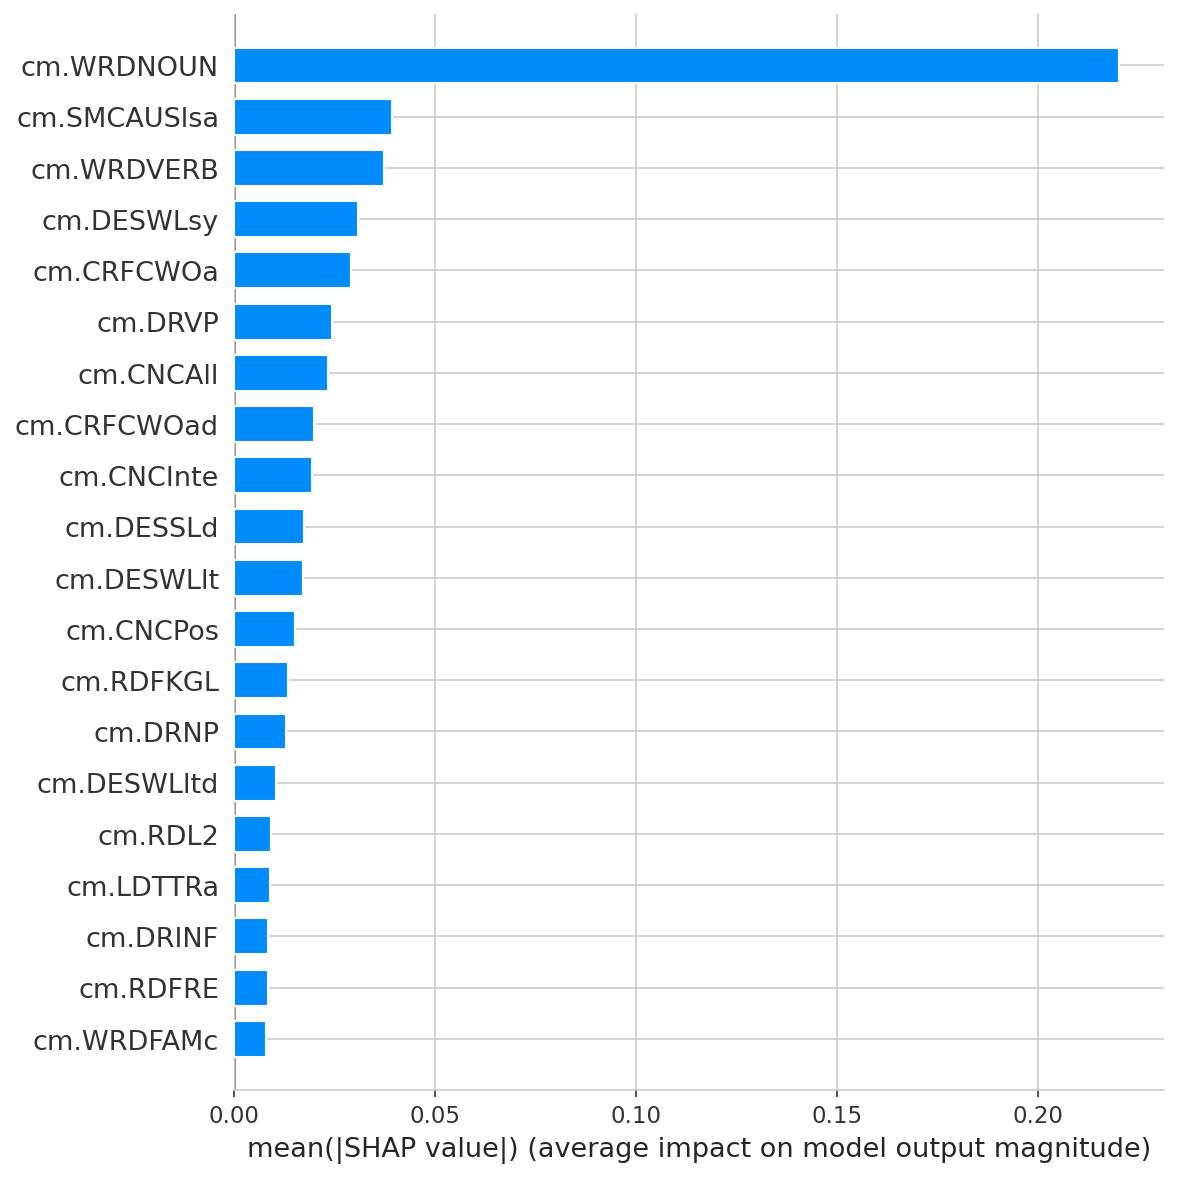

In [31]:
plt.figure(figsize = (15,8))
ax = shap.summary_plot(shap_values, 
                       datasetCurrent.columns,
                       plot_type='bar')
plt.show()

In [32]:
type(shap_values)

shap._explanation.Explanation

In [33]:
clustering = shap.utils.hclust(X_train, y_train)

[14:26:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).


[14:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

No/low signal found from feature 4 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).


[14:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 10%|▉         | 9/94 [00:00<?, ?it/s]

[14:26:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 12%|█▏        | 11/94 [00:11<00:48,  1.69it/s]

[14:26:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 13%|█▎        | 12/94 [00:12<01:13,  1.12it/s]

[14:26:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 14%|█▍        | 13/94 [00:14<01:38,  1.22s/it]

[14:26:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 15%|█▍        | 14/94 [00:16<01:52,  1.41s/it]

[14:26:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 16%|█▌        | 15/94 [00:17<01:47,  1.36s/it]

[14:26:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 17%|█▋        | 16/94 [00:18<01:45,  1.35s/it]

[14:26:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 18%|█▊        | 17/94 [00:20<01:43,  1.35s/it]

[14:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 19%|█▉        | 18/94 [00:21<01:39,  1.30s/it]

[14:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 20%|██        | 19/94 [00:22<01:40,  1.34s/it]

[14:26:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 21%|██▏       | 20/94 [00:24<01:43,  1.40s/it]

[14:26:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 22%|██▏       | 21/94 [00:25<01:42,  1.41s/it]

[14:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 23%|██▎       | 22/94 [00:27<01:47,  1.49s/it]

[14:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 24%|██▍       | 23/94 [00:30<02:13,  1.88s/it]

[14:26:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 26%|██▌       | 24/94 [00:33<02:47,  2.39s/it]

[14:26:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 27%|██▋       | 25/94 [00:36<02:49,  2.45s/it]

[14:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 28%|██▊       | 26/94 [00:38<02:40,  2.36s/it]


[14:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of r

 29%|██▊       | 27/94 [00:42<03:00,  2.70s/it]

[14:27:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 30%|██▉       | 28/94 [00:44<02:47,  2.54s/it]

[14:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

No/low signal found from feature 27 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 28 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).


[14:27:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 33%|███▎      | 31/94 [00:45<01:26,  1.38s/it]

[14:27:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 34%|███▍      | 32/94 [00:47<01:25,  1.37s/it]

[14:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 35%|███▌      | 33/94 [00:48<01:22,  1.35s/it]

[14:27:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 36%|███▌      | 34/94 [00:49<01:22,  1.38s/it]

[14:27:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 37%|███▋      | 35/94 [00:51<01:21,  1.39s/it]

[14:27:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 38%|███▊      | 36/94 [00:52<01:20,  1.39s/it]

[14:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 39%|███▉      | 37/94 [00:54<01:21,  1.44s/it]

[14:27:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 40%|████      | 38/94 [00:56<01:28,  1.58s/it]

[14:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 41%|████▏     | 39/94 [00:57<01:27,  1.59s/it]

[14:27:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 43%|████▎     | 40/94 [00:59<01:22,  1.52s/it]

[14:27:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 44%|████▎     | 41/94 [01:00<01:12,  1.37s/it]

[14:27:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 45%|████▍     | 42/94 [01:01<01:14,  1.43s/it]

[14:27:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 46%|████▌     | 43/94 [01:03<01:25,  1.68s/it]

[14:27:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 47%|████▋     | 44/94 [01:05<01:17,  1.55s/it]

[14:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 48%|████▊     | 45/94 [01:05<01:04,  1.33s/it]

[14:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 49%|████▉     | 46/94 [01:07<01:12,  1.51s/it]

[14:27:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 50%|█████     | 47/94 [01:10<01:22,  1.76s/it]

[14:27:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 51%|█████     | 48/94 [01:12<01:29,  1.95s/it]

[14:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 52%|█████▏    | 49/94 [01:14<01:24,  1.88s/it]


[14:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of r

 53%|█████▎    | 50/94 [01:16<01:25,  1.94s/it]


[14:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of r

 54%|█████▍    | 51/94 [01:19<01:33,  2.18s/it]

[14:27:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

No/low signal found from feature 50 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).


[14:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 56%|█████▋    | 53/94 [01:22<01:18,  1.92s/it]

[14:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 57%|█████▋    | 54/94 [01:24<01:18,  1.96s/it]

[14:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 59%|█████▊    | 55/94 [01:26<01:22,  2.10s/it]

[14:27:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 60%|█████▉    | 56/94 [01:29<01:22,  2.18s/it]

[14:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 61%|██████    | 57/94 [01:32<01:25,  2.31s/it]

[14:27:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 62%|██████▏   | 58/94 [01:34<01:22,  2.28s/it]

[14:27:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 63%|██████▎   | 59/94 [01:36<01:17,  2.22s/it]


[14:27:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of r

 64%|██████▍   | 60/94 [01:40<01:32,  2.73s/it]

[14:28:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 65%|██████▍   | 61/94 [01:42<01:23,  2.54s/it]

[14:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 66%|██████▌   | 62/94 [01:44<01:12,  2.28s/it]

[14:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 67%|██████▋   | 63/94 [01:46<01:08,  2.22s/it]

[14:28:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 68%|██████▊   | 64/94 [01:48<01:04,  2.17s/it]

[14:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 69%|██████▉   | 65/94 [01:51<01:11,  2.47s/it]

[14:28:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 70%|███████   | 66/94 [01:54<01:12,  2.57s/it]

[14:28:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 71%|███████▏  | 67/94 [01:55<01:02,  2.30s/it]

[14:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 72%|███████▏  | 68/94 [01:57<00:54,  2.09s/it]

[14:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 73%|███████▎  | 69/94 [01:58<00:46,  1.85s/it]

[14:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 74%|███████▍  | 70/94 [01:59<00:39,  1.66s/it]

[14:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 76%|███████▌  | 71/94 [02:01<00:35,  1.52s/it]

[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

No/low signal found from feature 70 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).


[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 78%|███████▊  | 73/94 [02:02<00:21,  1.04s/it]

[14:28:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 79%|███████▊  | 74/94 [02:03<00:23,  1.17s/it]

[14:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 80%|███████▉  | 75/94 [02:05<00:26,  1.37s/it]

[14:28:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 81%|████████  | 76/94 [02:07<00:25,  1.43s/it]

[14:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 82%|████████▏ | 77/94 [02:08<00:26,  1.55s/it]

[14:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 83%|████████▎ | 78/94 [02:10<00:26,  1.64s/it]

[14:28:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 84%|████████▍ | 79/94 [02:13<00:27,  1.82s/it]

[14:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

No/low signal found from feature 78 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 79 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 80 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).


[14:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 88%|████████▊ | 83/94 [02:15<00:10,  1.00it/s]

[14:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 89%|████████▉ | 84/94 [02:16<00:09,  1.00it/s]

[14:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 90%|█████████ | 85/94 [02:17<00:10,  1.14s/it]

[14:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 91%|█████████▏| 86/94 [02:20<00:11,  1.38s/it]

[14:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 93%|█████████▎| 87/94 [02:23<00:13,  1.91s/it]

[14:28:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 94%|█████████▎| 88/94 [02:30<00:19,  3.23s/it]

[14:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 95%|█████████▍| 89/94 [02:32<00:15,  3.00s/it]

[14:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 96%|█████████▌| 90/94 [02:34<00:10,  2.64s/it]

[14:28:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 97%|█████████▋| 91/94 [02:35<00:06,  2.21s/it]

[14:28:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 98%|█████████▊| 92/94 [02:36<00:03,  1.92s/it]

[14:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 99%|█████████▉| 93/94 [02:38<00:01,  1.73s/it]

[14:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

100%|██████████| 94/94 [02:39<00:00,  1.67s/it]

[14:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

95it [02:41,  1.87s/it]

[14:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

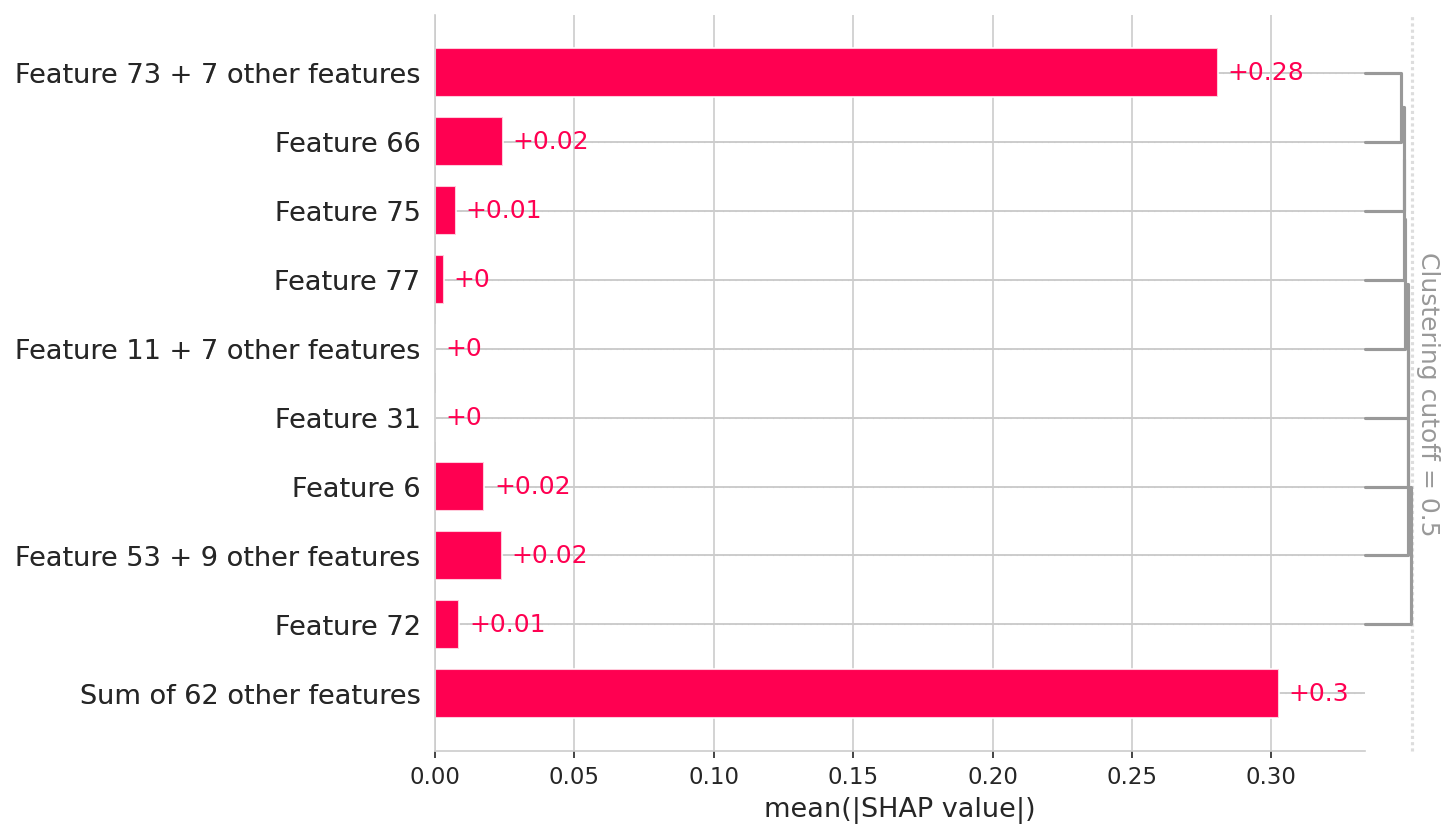

In [34]:
shap.plots.bar(shap_values, clustering=clustering)

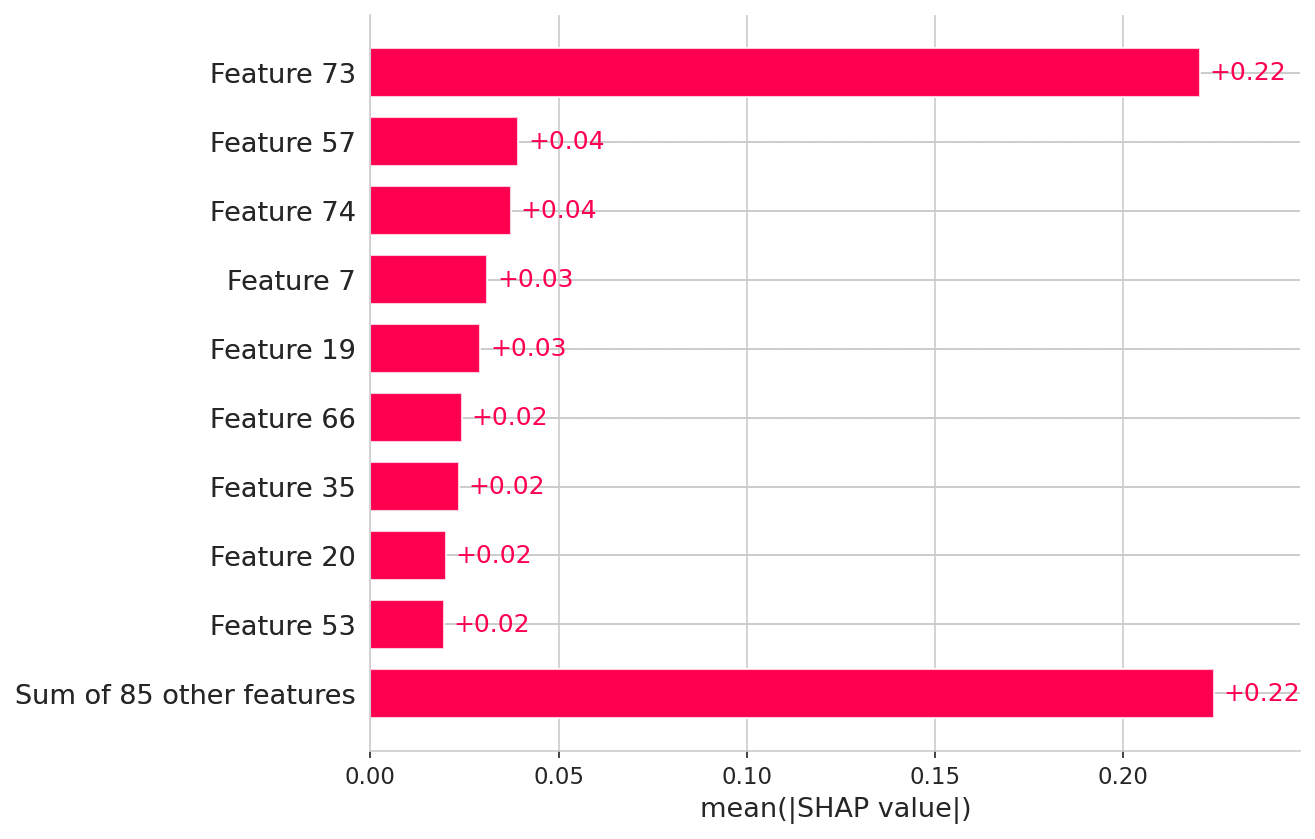

In [35]:
shap.plots.bar(shap_values, max_display=10)

Cross Validation - Scikit-Learn's Random Forest Classifier

In [36]:
#from sklearn.model_selection import cross_val_score
#rfc_cv = RandomForestClassifier(n_estimators=100)
#scores = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
#print("Scores:", scores)
#print("Mean:", scores.mean())
#print("Standard Deviation:", scores.std())

XGBoost

In [37]:
#xgb_cv = XGBClassifier(n_estimators=100)
#scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
#print("Scores:", scores)
#print("Mean:", scores.mean())
#print("Standard Deviation:", scores.std())

The best parameters for prediction as found by the tuning tests are:

max_depth = 5
min_child_weight = 1
gamma = 0
subsample = 0.8
colsample_bytree = 0.8
reg_alpha = 0.005

In [38]:
X_train, X_test, y_train, y_test = train_test_split(datasetCurrent.drop('classe', axis=1), datasetCurrent['classe'],
                                                   test_size=0.33)

In [39]:
xgboost = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=100, gamma=0, 
                        min_child_weight=1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005)

xgboost.fit(X_train, y_train)
preds = xgboost.predict(X_test)

accuracy = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy WITH optimal hyperparameters is: %3.2f" % (accuracy))

XGBoost's prediction accuracy WITH optimal hyperparameters is: 96.21


In [40]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.93023256 0.97674419 0.90697674 0.88372093 0.90697674 0.95348837
 0.95348837 0.95238095 0.95238095 0.95238095]
Mean: 0.93687707641196
Standard Deviation: 0.02742289638853819


# XGBoost - Evaluation

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 200, 1: 198}

In [ ]:
predictions = cross_val_predict(xgb, X_test, y_test, cv=5)
confusion_matrix(y_test, predictions)

array([[198,   2],
       [  8, 190]])

In [ ]:
print("Precision:", precision_score(y_test, predictions, average='micro'))
print("Recall:",recall_score(y_test, predictions, average='micro'))

Precision: 0.9748743718592965
Recall: 0.9748743718592965


In [ ]:
print("F1-Score:", f1_score(y_test, predictions, average='micro'))

F1-Score: 0.9748743718592965
